In [1]:
####### dropout resnet18 vs without dropout
#### 
import torch
import sys
sys.path.append("..")
import numpy as np

CLEAN_PATH = "/home/yifan/dataset/resnet18_with_dropout/pairflip/cifar10/0/"
REF_PATH = "/home/yifan/dataset/clean/pairflip/cifar10/0"


ENCODER_DIMS=[512,256,256,256,256,2]
DECODER_DIMS= [2,256,256,256,256,512]
VIS_MODEL_NAME = 'vis'

DEVICE='cuda:0'
########## initulize reference data and target data
from alignment.data_preprocess import DataInit
REF_EPOCH = 200
TAR_EPOCH = 200
ref_datainit = DataInit(REF_PATH,REF_PATH,REF_EPOCH)
tar_datainit = DataInit(CLEAN_PATH,CLEAN_PATH,TAR_EPOCH)
ref_model, ref_provider, ref_train_data, ref_prediction, ref_prediction_res, ref_scores = ref_datainit.getData()
tar_model, tar_provider, tar_train_data, tar_prediction, tar_prediction_res, tar_scores = tar_datainit.getData()


from alignment.ReferenceGenerator import ReferenceGenerator
gen = ReferenceGenerator(ref_provider=ref_provider, tar_provider=tar_provider,REF_EPOCH=REF_EPOCH,TAR_EPOCH=TAR_EPOCH,ref_model=ref_model,tar_model=tar_model,DEVICE=DEVICE)

absolute_alignment_indicates,predict_label_diff_indicates,predict_confidence_Diff_indicates,high_distance_indicates = gen.subsetClassify(mes_val_for_diff=18,mes_val_for_same=0.8,conf_val_for_diff=0.3,conf_val_for_same=0.05)


from representationTrans.trans_visualizer_border import visualizer
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)

I = np.eye(512)
projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")
vis = visualizer(ref_provider, I,I, np.dot(ref_provider.train_representation(TAR_EPOCH),I), projector, 200,[0,1],'tab10')


/home/yifan/miniconda3/envs/deepdebugger/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


NET resnet18
Finish initialization...


100%|██████████| 250/250 [00:00<00:00, 443.59it/s]


NET resnet18_with_dropout
Finish initialization...


100%|██████████| 250/250 [00:00<00:00, 7588.42it/s]


absolute alignment indicates number: 106 label diff indicates number: 12 confidence diff indicates number: 16 high distance number: 97


In [2]:
from AlignVis.autoencoder import Autoencoder
X = torch.Tensor(ref_train_data)
Y = torch.Tensor(tar_train_data)

In [3]:
X = torch.Tensor(ref_train_data)
Y = torch.Tensor(tar_train_data)

In [54]:
def train_autoencoder(X, Y, output_dim):
    input_dim = X.shape[1]
    autoencoder = Autoencoder(input_dim, output_dim)
    optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)
    criterion = nn.MSELoss()

    # Concatenate X and Y
    input_data = torch.cat([X, Y], dim=0)

    # Normalize the input data
    input_data = (input_data - input_data.mean()) / input_data.std()
    

    # Train the autoencoder
    for epoch in range(100):
        optimizer.zero_grad()
        output_data = autoencoder(input_data)
        loss = criterion(output_data, input_data)
        
        loss.backward()
        optimizer.step()
        print("epoch",epoch,"loss",loss)
   

    # Extract the transformed data Y_trans
    with torch.no_grad():
        encoded_Y = autoencoder.encoder(Y)
        Y_trans = autoencoder.decoder(encoded_Y)

    # Compute the Frobenius norm between X and Y_trans
    fro_norm = torch.norm(X - Y_trans, p='fro')

    # Compute the CKA between Y and Y_trans
    Y = (Y - Y.mean()) / Y.std()
    Y_trans = (Y_trans - Y_trans.mean()) / Y_trans.std()
    dot_prod = torch.dot(Y.flatten(), Y_trans.flatten())
    cka = dot_prod**2 / (torch.norm(Y.flatten())**2 * torch.norm(Y_trans.flatten())**2)

    return Y_trans, fro_norm.item(), cka.item()

In [4]:
# Set the hyperparameters
input_dim = 512
hidden_dim = 2
lr = 0.01
num_epochs = 100

In [8]:
import torch.optim as optim
import torch.nn as nn
from sklearn.metrics.pairwise import euclidean_distances
def train_autoencoder(X, Y, output_dim):
    input_dim = X.shape[1]
    bottleneck_dim = min(input_dim, output_dim) // 2  # Choose the bottleneck dimension as half of the minimum of input and output dimensions
    autoencoder = nn.Sequential(
        nn.Linear(input_dim, bottleneck_dim),
        nn.ReLU(),
        nn.Linear(bottleneck_dim, output_dim),
        nn.ReLU(),
    )
    optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)
    criterion = nn.MSELoss()

    # Concatenate a subset of X and Y
    n_samples = min(X.shape[0], Y.shape[0])
    input_data = torch.cat([X[:n_samples], Y], dim=0)

    # Normalize the input data
    input_data = (input_data - input_data.mean()) / input_data.std()

    # Train the autoencoder
    for epoch in range(100):
        optimizer.zero_grad()
        output_data = autoencoder(input_data)
        loss = criterion(output_data, input_data) + criterion(output_data[n_samples:], Y)
        loss.backward()
        optimizer.step()
        print("epoch", epoch, "loss", loss)

    # Extract the transformed data Y_trans
    with torch.no_grad():
        encoded_Y = autoencoder(Y)
        Y_trans = autoencoder[1](encoded_Y)

    # Compute the Frobenius norm between X and Y_trans
    fro_norm = torch.norm(X[:n_samples] - Y_trans, p='fro')

    # Compute the CKA between Y and Y_trans
    Y = (Y - Y.mean()) / Y.std()
    Y_trans = (Y_trans - Y_trans.mean()) / Y_trans.std()
    dot_prod = torch.dot(Y.flatten(), Y_trans.flatten())
    cka = dot_prod**2 / (torch.norm(Y.flatten())**2 * torch.norm(Y_trans.flatten())**2)

    return Y_trans, fro_norm.item(), cka.item()


In [9]:

Y_trans, norm, cka = train_autoencoder(Y, X, input_dim)


epoch 0 loss tensor(2.1383, grad_fn=<AddBackward0>)
epoch 1 loss tensor(2.0508, grad_fn=<AddBackward0>)
epoch 2 loss tensor(1.9523, grad_fn=<AddBackward0>)
epoch 3 loss tensor(1.8497, grad_fn=<AddBackward0>)
epoch 4 loss tensor(1.7511, grad_fn=<AddBackward0>)
epoch 5 loss tensor(1.6647, grad_fn=<AddBackward0>)
epoch 6 loss tensor(1.5934, grad_fn=<AddBackward0>)
epoch 7 loss tensor(1.5329, grad_fn=<AddBackward0>)
epoch 8 loss tensor(1.4760, grad_fn=<AddBackward0>)
epoch 9 loss tensor(1.4186, grad_fn=<AddBackward0>)
epoch 10 loss tensor(1.3611, grad_fn=<AddBackward0>)
epoch 11 loss tensor(1.3064, grad_fn=<AddBackward0>)
epoch 12 loss tensor(1.2567, grad_fn=<AddBackward0>)
epoch 13 loss tensor(1.2132, grad_fn=<AddBackward0>)
epoch 14 loss tensor(1.1753, grad_fn=<AddBackward0>)
epoch 15 loss tensor(1.1419, grad_fn=<AddBackward0>)
epoch 16 loss tensor(1.1120, grad_fn=<AddBackward0>)
epoch 17 loss tensor(1.0848, grad_fn=<AddBackward0>)
epoch 18 loss tensor(1.0600, grad_fn=<AddBackward0>)
epo

In [8]:
cka

0.9592973589897156

In [11]:
X

tensor([[0.0000, 0.0000, 1.3862,  ..., 2.0161, 0.6060, 0.4670],
        [2.3885, 1.8560, 0.6664,  ..., 0.6171, 2.1145, 1.7129],
        [1.6156, 2.0472, 0.9266,  ..., 0.2589, 1.1149, 1.2194],
        ...,
        [2.3992, 2.4024, 0.5423,  ..., 0.0914, 0.8866, 1.4072],
        [1.6173, 0.2200, 1.0360,  ..., 2.0317, 0.6699, 1.9716],
        [0.8757, 0.4554, 0.5180,  ..., 0.1630, 0.8817, 2.3847]])

In [10]:
Y_trans

tensor([[-0.3281,  0.3612, -0.9346,  ...,  1.4319,  1.0869, -0.9346],
        [ 0.9457, -0.9346,  2.0378,  ..., -0.9346,  0.0854, -0.9346],
        [ 0.4329, -0.9067,  0.5681,  ..., -0.9346,  0.3593, -0.9346],
        ...,
        [ 1.1641, -0.9346,  0.3138,  ..., -0.9346, -0.6921, -0.9346],
        [ 0.7906, -0.9346,  0.6621,  ..., -0.3222,  0.2386,  2.3335],
        [ 0.6299, -0.7909,  1.8133,  ..., -0.9346,  0.7277,  0.3689]])

In [16]:
from AlignVis.AlignMetrixGenerator import TrainingSnapshotAlignment
alignment_n = TrainingSnapshotAlignment(ref_provider, tar_provider,ref_EPOCH=REF_EPOCH,tar_EPOCH=TAR_EPOCH, projector=projector, visualizer=vis)
R_n = alignment_n.align_embeddings_batch(Y_trans.detach().numpy(),X,train_steps=2000,CKA_LAMBDA=10,CKA_LAMBAD_FOR_INIT=1e-5,N_LAMBDA=10)

batch_idx 0,iteration 0, loss1 5164296.5 loss2 {tensor(0.7807, grad_fn=<AddBackward0>)} neibour_loss {tensor(0.8400, requires_grad=True)}
batch_idx 199,iteration 199, loss1 124556.0390625 loss2 {tensor(0.8696, grad_fn=<AddBackward0>)} neibour_loss {tensor(0.8830, requires_grad=True)}
batch_idx 398,iteration 398, loss1 8708.228515625 loss2 {tensor(0.9013, grad_fn=<AddBackward0>)} neibour_loss {tensor(0.8520, requires_grad=True)}
batch_idx 97,iteration 597, loss1 4775.07177734375 loss2 {tensor(0.8804, grad_fn=<AddBackward0>)} neibour_loss {tensor(0.8100, requires_grad=True)}
batch_idx 296,iteration 796, loss1 3805.173095703125 loss2 {tensor(0.8965, grad_fn=<AddBackward0>)} neibour_loss {tensor(0.8120, requires_grad=True)}
batch_idx 495,iteration 995, loss1 3473.456787109375 loss2 {tensor(0.8882, grad_fn=<AddBackward0>)} neibour_loss {tensor(0.8090, requires_grad=True)}
batch_idx 194,iteration 1194, loss1 2504.349365234375 loss2 {tensor(0.8650, grad_fn=<AddBackward0>)} neibour_loss {tenso

In [18]:
from AlignVis.AlignMetrixGenerator import TrainingSnapshotAlignment
alignment_n = TrainingSnapshotAlignment(ref_provider, tar_provider,ref_EPOCH=REF_EPOCH,tar_EPOCH=TAR_EPOCH, projector=projector, visualizer=vis)
R_n_2 = alignment_n.align_embeddings_batch(Y,X,train_steps=2000,CKA_LAMBDA=10,CKA_LAMBAD_FOR_INIT=1e-5,N_LAMBDA=10)

batch_idx 0,iteration 0, loss1 65502392.0 loss2 {tensor(0.7832, grad_fn=<AddBackward0>)} neibour_loss {tensor(0.8510, requires_grad=True)}
batch_idx 199,iteration 199, loss1 594.7369384765625 loss2 {tensor(0.5502, grad_fn=<AddBackward0>)} neibour_loss {tensor(0.5020, requires_grad=True)}
batch_idx 398,iteration 398, loss1 235.75448608398438 loss2 {tensor(0.3989, grad_fn=<AddBackward0>)} neibour_loss {tensor(0.4880, requires_grad=True)}
batch_idx 97,iteration 597, loss1 217.1630859375 loss2 {tensor(0.3636, grad_fn=<AddBackward0>)} neibour_loss {tensor(0.4440, requires_grad=True)}
batch_idx 296,iteration 796, loss1 230.03338623046875 loss2 {tensor(0.3913, grad_fn=<AddBackward0>)} neibour_loss {tensor(0.4450, requires_grad=True)}
batch_idx 495,iteration 995, loss1 209.22866821289062 loss2 {tensor(0.3384, grad_fn=<AddBackward0>)} neibour_loss {tensor(0.3950, requires_grad=True)}
batch_idx 194,iteration 1194, loss1 195.50726318359375 loss2 {tensor(0.3312, grad_fn=<AddBackward0>)} neibour_lo

In [11]:
from AlignVis.AlignMetrixGenerator import TrainingSnapshotAlignment
alignment_n = TrainingSnapshotAlignment(ref_provider, tar_provider,ref_EPOCH=REF_EPOCH,tar_EPOCH=TAR_EPOCH, projector=projector, visualizer=vis)
R_n_3 = alignment_n.align_embeddings_batch(Y,Y_trans,train_steps=2000,CKA_LAMBDA=10,CKA_LAMBAD_FOR_INIT=1e-5,N_LAMBDA=10)

batch_idx 0,iteration 0, loss1 65800936.0 loss2 {tensor(0.8183, grad_fn=<AddBackward0>)} neibour_loss {tensor(0.8510, requires_grad=True)}
batch_idx 199,iteration 199, loss1 648.26318359375 loss2 {tensor(0.4255, grad_fn=<AddBackward0>)} neibour_loss {tensor(0.4050, requires_grad=True)}
batch_idx 398,iteration 398, loss1 283.6435852050781 loss2 {tensor(0.2610, grad_fn=<AddBackward0>)} neibour_loss {tensor(0.3990, requires_grad=True)}
batch_idx 97,iteration 597, loss1 259.8157043457031 loss2 {tensor(0.2284, grad_fn=<AddBackward0>)} neibour_loss {tensor(0.3530, requires_grad=True)}
batch_idx 296,iteration 796, loss1 266.720458984375 loss2 {tensor(0.2488, grad_fn=<AddBackward0>)} neibour_loss {tensor(0.3250, requires_grad=True)}
batch_idx 495,iteration 995, loss1 226.9960174560547 loss2 {tensor(0.1911, grad_fn=<AddBackward0>)} neibour_loss {tensor(0.3130, requires_grad=True)}
batch_idx 194,iteration 1194, loss1 221.45297241210938 loss2 {tensor(0.1938, grad_fn=<AddBackward0>)} neibour_loss 

In [12]:
Y_trans.shape

torch.Size([50000, 512])

Computing decision regions ...


100%|██████████| 250/250 [00:00<00:00, 8413.31it/s]


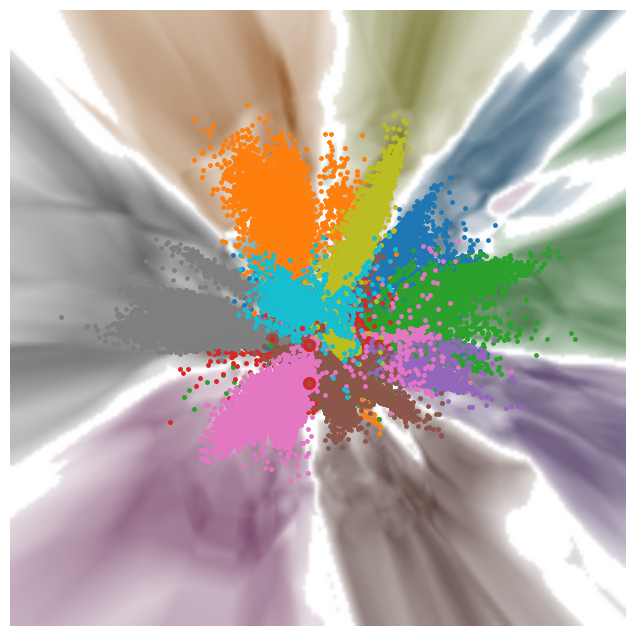

In [12]:
import json
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)

projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

I = np.eye(512)
# from AlignVis.visualizerwr import visualizer
from representationTrans.trans_visualizer_border import visualizer
vis = visualizer(ref_provider,I,I, np.dot(Y,R_n_3.detach().numpy()), projector, 200,[],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join("/home/yifan/projects/deepdebugertool/DLVisDebugger/alignment_evaluation/img1.png"))

Computing decision regions ...


100%|██████████| 250/250 [00:00<00:00, 8576.19it/s]


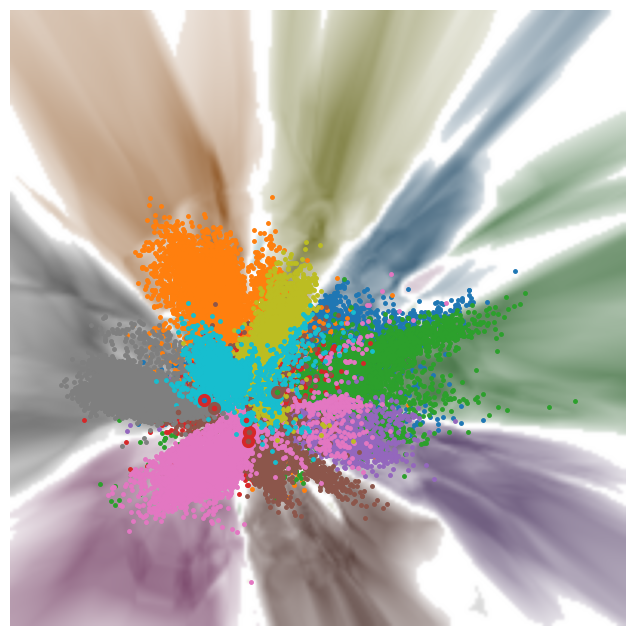

In [10]:
import json
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)

projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

I = np.eye(512)
# from AlignVis.visualizerwr import visualizer
from representationTrans.trans_visualizer_border import visualizer
vis = visualizer(ref_provider,I,I, np.dot(Y_trans.detach().numpy(),I), projector, 200,[],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join("/home/yifan/projects/deepdebugertool/DLVisDebugger/alignment_evaluation/img1.png"))

Computing decision regions ...


100%|██████████| 250/250 [00:00<00:00, 8134.04it/s]


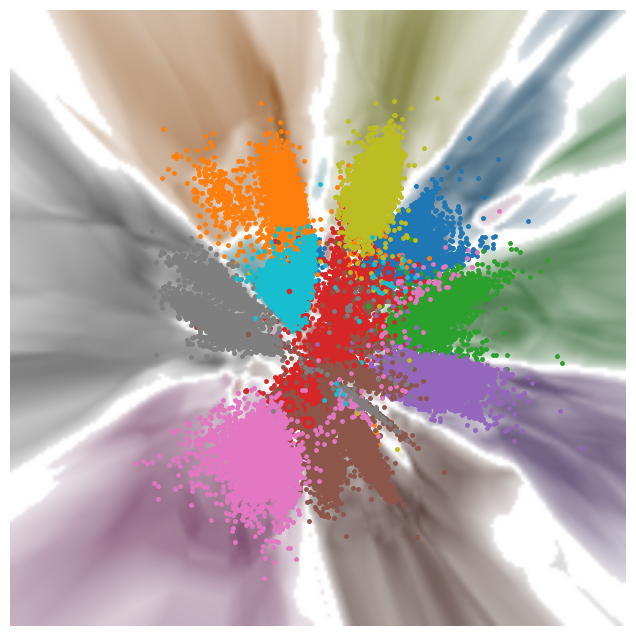

In [40]:
import json
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)

projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

I = np.eye(512)
# from AlignVis.visualizerwr import visualizer
from representationTrans.trans_visualizer_border import visualizer
vis = visualizer(ref_provider,I,I, np.dot(ref_train_data,I), projector, 200,[],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join("/home/yifan/projects/deepdebugertool/DLVisDebugger/alignment_evaluation/img1.png"))